# Performance Baselines

In [1]:
import watermark
import pandas as pd
import numpy as np
# from xgboost import XGBRegressor
import datetime
import random
import copy
import os
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import HistGradientBoostingRegressor
import ray
from tqdm import tqdm

%reload_ext watermark
%watermark -p xgboost,pandas,numpy,scikit-learn
!python --version

xgboost     : not installed
pandas      : 1.2.4
numpy       : 1.20.1
scikit-learn: 0.24.1

Python 3.8.8


## Dataset

In [2]:
# Read ratings df
path = "data_small"
use_large = False
if (use_large):
    path = "data_large"
    ratings = pd.read_csv('./' + path + '/ratings.csv')[:1000000]
else:
    ratings = pd.read_csv('./' + path + '/ratings.csv')

movies = pd.read_csv('./' + path + '/movies.csv')

print(ratings)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


In [3]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
genres_set = set()
for string in tqdm(movies.genres):
    genres_set.update(string.split('|'))
#genres.remove('(no genres listed)')
genres = sorted(genres_set)
print(genres)

100%|██████████████████████████████████████████████████████████████████████████| 9742/9742 [00:00<00:00, 885566.19it/s]

['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [5]:
for genre in genres:
    ratings[genre] = False

for movie in tqdm(movies.movieId):
    for genre in movies.genres[movies.loc[movies.movieId == movie].index[0]].split('|'):
        ratings.loc[ratings.movieId == movie, [genre]] = True

100%|█████████████████████████████████████████████████████████████████████████████| 9742/9742 [00:42<00:00, 229.66it/s]


In [6]:
# Delete movies with fewer than 25 ratings
data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
print(ratings.shape)
to_del = list()
counts = data.count(axis = 0, numeric_only = True)
for i in data.columns.values:
    if (counts[i] < 25):
        to_del.append(i)
ratings = ratings[~(ratings.movieId.isin(to_del))]
print(ratings.shape)
del data

(100836, 24)
(62518, 24)


In [7]:
@ray.remote
def insufficient_ratings(dataset, user):
    user_ratings = sum(dataset.userId == user)
    if (user_ratings < 20):
        return user
    return -1

In [8]:
# Removes users who no longer have 20 ratings

def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])

dat = ray.put(ratings)
obj_ids = [insufficient_ratings.remote(dat, user) for user in ratings.userId.unique()]
results = []
for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
    if x > -1:
        results.append(x)

ratings = ratings.loc[~(ratings.userId.isin(results))]

del dat
        
print("There were", len(results), "users with fewer than 20 ratings. They have been removed from the dataset.")

100%|███████████████████████████████████████████████████████████████████████████████| 610/610 [00:02<00:00, 267.91it/s]

There were 61 users with fewer than 20 ratings. They have been removed from the dataset.


In [9]:
# Note that GroupShuffleSplit allows us to have distinct users in the training, validation, and test sets

# Split into 80-20 training - testing split
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(ratings, groups=ratings.userId))

train_val = ratings.iloc[train_inds].copy()
test = ratings.iloc[test_inds].copy()

# Split into 80-20 training - validation split
train_inds, val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(train_val, groups=train_val.userId))

training = train_val.iloc[train_inds].copy()
validation = train_val.iloc[val_inds].copy()

print('Train/Valid/Test sizes:', training.shape[0], validation.shape[0], test.shape[0])

Train/Valid/Test sizes: 38700 10195 12724


In [10]:
# As it is, this will take the 10 most recent ratings for a user to use for prediction
# Commented out sections allow random ratings to be taken

@ray.remote
def prepare_helper(user, dataset):
    #random.seed(1)
    user_ratings = dataset.loc[dataset.userId == user]
                               
    # Randomly select 10 movies to remove
    #selected_movies = random.sample(range(0, user_ratings.shape[0]), 10)
    #selected_movies = random.choices(list(user_ratings.movieId), k=10)
                               
    # This will select the 10 most recent ratings for this user
    selected_movies = user_ratings.sort_values(by = "timestamp", ascending = False).movieId.values[0:10]
    
    # Add the removed movies to the removed dataframe
    removed_movies = user_ratings[user_ratings.movieId.isin(selected_movies)]
    
    return removed_movies

In [11]:
# This function takes in either the validation or training set
# Removes the most recent 10 ratings for each user, and returns them as removed_movies
# Returns the original dataset with the ratings to predict removed as new_movies
def prepare_data(dataset):
    # For validation and test data, remove 10 rated movies to be predicted
    removed_movies = pd.DataFrame(columns = dataset.columns)
    # Iterate over each user
    
    def to_iterator(obj_ids):
        while obj_ids:
            done, obj_ids = ray.wait(obj_ids)
            yield ray.get(done[0])
    dat = ray.put(dataset)
    obj_ids = [prepare_helper.remote(user, dat) for user in dataset["userId"].unique()]
    results = []
    for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
        results.append(x)
    
    # Combine removed movies:
    for result in tqdm(results):
        removed_movies = pd.concat([removed_movies, result])
        
    # Remove all of the user-movie combinations in removed_moviews from dataset
    new_movies = pd.merge(dataset, removed_movies, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    del dat
    
    return removed_movies, new_movies

In [12]:
# Get the proper splits for the validation and testing sets
if (os.path.isfile('./' + path + '/validation_removed_tmp.csv') and os.path.isfile('./' + path + '/validation_new.csv')):
    print("Validation set already exists" )
    validation_removed = pd.read_csv('./' + path + '/validation_removed_tmp.csv')
    validation_new = pd.read_csv('./' + path + '/validation_new.csv')
else:
    start = datetime.datetime.now()
    ray.init(ignore_reinit_error=True)
    validation_removed, validation_new = prepare_data(validation)
    print('Time building validation set: {}'.format(datetime.datetime.now()-start))
    validation_removed.to_csv('./' + path + '/validation_removed_tmp.csv')
    validation_new.to_csv('./' + path + '/validation_new.csv')

if (os.path.isfile('./' + path + '/test_removed_tmp.csv') and os.path.isfile('./' + path + '/test_new.csv')):
    print("Test set already exists" )
    test_removed = pd.read_csv('./' + path + '/test_removed_tmp.csv')
    test_new = pd.read_csv('./' + path + '/test_new.csv')                                                                
else:
    start = datetime.datetime.now()
    ray.init(ignore_reinit_error=True)
    test_removed, test_new = prepare_data(test)
    print('Time building test set: {}'.format(datetime.datetime.now()-start))
    test_removed.to_csv('./' + path + '/test_removed_tmp.csv')
    test_new.to_csv('./' + path + '/test_new.csv')

Validation set already exists
Test set already exists


In [13]:
# Return tuple of (user, average rating for user)
@ray.remote
def add_user(dataset, user):
    return (user, np.mean(dataset[dataset["userId"] == user]["rating"]))

In [14]:
# Returns dataset with the average user rating for each user
# Optionally takes in removed when using validation or test data
def user_avg(dataset, using_removed = False, removed = pd.DataFrame()):
    def to_iterator(obj_ids):
        while obj_ids:
            done, obj_ids = ray.wait(obj_ids)
            yield ray.get(done[0])

    # Get the user averages
    dataset["userAvg"] = 0.0
    dat = ray.put(dataset)
    obj_ids = ([add_user.remote(dat, user) for user in dataset.userId.unique()])
    results = []
    for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
        results.append(x)
    del dat

    if (using_removed):
        removed["userAvg"] = 0.0
    print("Combining data")
    for result in tqdm(results):
        dataset.loc[dataset["userId"] == result[0], ["userAvg"]] = result[1]
        if (using_removed):
            removed.loc[removed.userId == result[0], ["userAvg"]] = result[1]
    
    return dataset, removed

In [15]:
# Return tuple of (movie, average rating for movie)
@ray.remote
def add_movie(dataset, movie):
    return (movie, np.mean(dataset[dataset["movieId"] == movie]["rating"]))

In [16]:
# Returns dataset with the average movie rating for each movie
def movie_avg(dataset, removed):
    def to_iterator(obj_ids):
        while obj_ids:
            done, obj_ids = ray.wait(obj_ids)
            yield ray.get(done[0])

    # Get the movie averages
    dataset["movieAvg"] = 0.0
    dat = ray.put(dataset)
    obj_ids = ([add_movie.remote(dat, movie) for movie in dataset.movieId.unique()])
    results = []
    for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
        results.append(x)
    del dat
    
    removed["movieAvg"] = 0.0
    print("Combining data")
    for result in tqdm(results):
        dataset.loc[dataset["movieId"] == result[0], ["movieAvg"]] = result[1]
        removed.loc[removed.movieId == result[0], ["movieAvg"]] = result[1]
        
    return dataset, removed

In [17]:
# Return datasets with average movie rating and average user rating for each row
def add_avgs(training, validation_new, test_new, validation_removed, test_removed):
    print("\nCalculating training set user averages")
    training, dummy = user_avg(training, False)
    print("\nCalculating validation set user averages")
    validation_new, validation_removed = user_avg(validation_new, True, validation_removed)
    print("\nCalculating test set user averages")
    test_new, test_removed = user_avg(test_new, True, test_removed)
    
    print("\nCalculating validation set movie averages")
    training_validation, validation_removed = movie_avg(pd.concat([training, validation_new]), validation_removed)
    
    print("\nCalculating test set movie averages")
    training_test, test_removed = movie_avg(pd.concat([training, test_new]), test_removed)
    
    return training_validation, training_test, validation_removed, test_removed

In [18]:
if (os.path.isfile('./' + path + '/training_validation.csv') and os.path.isfile('./' + path + '/training_test.csv') and os.path.isfile('./' + path + '/validation_removed.csv') and os.path.isfile('./' + path + '/test_removed.csv')):
    print("Sets already exists" )
    training_validation = pd.read_csv('./' + path + '/training_validation.csv')
    training_test = pd.read_csv('./' + path + '/training_test.csv')
    validation_removed = pd.read_csv('./' + path + '/validation_removed.csv')
    test_removed = pd.read_csv('./' + path + '/test_removed.csv')
else:
    
    # training_validation has all training data as well as the unremoved values in the validation data
    # this will be used to train, and we will use the removed validation data to predict
    
    # training_test has all training data as well as the unremoved values in the test data
    # this will be used to train, and we will use the removed test data to predict
    
    training_validation, training_test, validation_removed, test_removed = add_avgs(training, validation_new, test_new, validation_removed, test_removed)
    training_validation.to_csv('./' + path + '/training_validation.csv')
    training_test.to_csv('./' + path + '/training_test.csv')
    validation_removed.to_csv('./' + path + '/validation_removed.csv')
    test_removed.to_csv('./' + path + '/test_removed.csv')

Sets already exists


## Baselines

In [19]:
# 1. Predicting average global rating for every movie
global_avg = np.mean(training_validation["rating"])
ratings_pred = validation_removed.copy(deep=True).assign(rating = global_avg)
    
global_rmse = mean_squared_error(validation_removed["rating"], ratings_pred["rating"], squared = False)
print("RMSE for global avg:", global_rmse)

RMSE for global avg: 1.007699663575643


In [20]:
# 2. Predicting average movie rating for each movie
ratings_pred = validation_removed.copy(deep=True)

for movie in tqdm(validation_removed.movieId.unique()):
    if movie in training_validation.movieId.unique():
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = training_validation.loc[training_validation.movieId == movie, "movieAvg"].iat[0]
    
avg_movie_rmse = mean_squared_error(validation_removed["rating"], ratings_pred["rating"], squared = False)
print("RMSE for movie avg:", avg_movie_rmse)

100%|███████████████████████████████████████████████████████████████████████████████| 550/550 [00:01<00:00, 462.02it/s]

RMSE for movie avg: 0.9279114110631916


In [21]:
# 3. Predicting average user rating for each movie
ratings_pred = validation_removed.copy(deep=True)

for user in tqdm(validation_removed.userId.unique()):
    ratings_pred.loc[ratings_pred.userId == user, ["rating"]] = training_validation.loc[training_validation.userId == user, "userAvg"].iat[0]
    
avg_user_rmse = mean_squared_error(validation_removed["rating"], ratings_pred["rating"], squared = False)
print("RMSE for user avg:", avg_user_rmse)

100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 518.09it/s]

RMSE for user avg: 0.970671907398001


In [22]:
# 4. Predicting average of the range 0.5 - 5.0, which is 2.75 for every movie
range_avg = 2.75
ratings_pred = validation_removed.copy(deep=True).assign(rating = range_avg)
    
range_rmse = mean_squared_error(validation_removed["rating"], ratings_pred["rating"], squared = False)
print("RMSE for range avg:", range_rmse)

RMSE for range avg: 1.426215589976112


In [23]:
# 5. Predicting class with mode class
#print(training.rating.mode())
mode = 4.0
ratings_pred = validation_removed.copy(deep=True).assign(rating = mode)
    
mode_rmse = mean_squared_error(validation_removed["rating"], ratings_pred["rating"], squared = False)
print("RMSE for mode:", mode_rmse)

RMSE for mode: 1.0287072646596973


In [24]:
print("The lowest baseline RMSE is", min(global_rmse, avg_movie_rmse, avg_user_rmse, range_rmse, mode_rmse))

The lowest baseline RMSE is 0.9279114110631916


In [25]:
#The lowest baseline RMSE is 0.9279114110631916

In [26]:
#training_validation = training_validation.astype({'userId': str, 'movieId': str})
#training_test = training_test.astype({'userId': str, 'movieId': str})
#validation_removed = validation_removed.astype({'userId': str, 'movieId': str})
#test_removed = test_removed.astype({'userId': str, 'movieId': str})

## Models

In [27]:
#clf = HistGradientBoostingRegressor(learning_rate = 0.1, max_iter = 25, l2_regularization = 1, random_state = 1)
clf = XGBRegressor(eta=0.255, max_depth=5, min_child_weight = 4, n_estimators = 200, subsample = 0.70, n_jobs=-1, random_state=1)
#clf = AdaBoostRegressor(base_estimator = clf1, learning_rate = 0.01, n_estimators = 50, random_state = 1)

use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp']
use_cols.extend(genres)

x_train = training_validation[use_cols].to_numpy()
y_train = training_validation[['rating']]
x_val = validation_removed[use_cols].to_numpy()

start = datetime.datetime.now()
clf.fit(x_train, np.ravel(y_train))
print('Time building model: {}'.format(datetime.datetime.now()-start))

ratings_pred = clf.predict(x_val)
xgb_val_rmse = mean_squared_error(validation_removed["rating"], ratings_pred, squared = False)
print("RMSE for XGBoost validation set:", xgb_val_rmse)

Time building model: 0:00:02.976089
RMSE for XGBoost validation set: 0.9147754471789399


In [28]:
#Time building model: 0:00:02.446730
#RMSE for XGBoost validation set: 0.9147754471789399

In [29]:
x_train = training_test[use_cols].to_numpy()
y_train = training_test[['rating']]
x_test = test_removed[use_cols].to_numpy()

start = datetime.datetime.now()
clf.fit(x_train, np.ravel(y_train))
print('Time building model: {}'.format(datetime.datetime.now()-start))

ratings_pred = clf.predict(x_test)

xgb_test_rmse = mean_squared_error(test_removed["rating"], ratings_pred, squared = False)
print("RMSE for XGBoost test set:", xgb_test_rmse)

Time building model: 0:00:03.254929
RMSE for XGBoost test set: 0.8594862008237355


In [30]:
#Time building model: 0:00:03.062357
#RMSE for XGBoost test set: 0.8594862008237355

In [31]:
# Baseline on test set
ratings_pred = test_removed.copy(deep=True)
for user in tqdm(training_test["userId"].unique()):
    ratings_pred.loc[ratings_pred["userId"] == user, ["rating"]] = training_test.loc[training_test.userId == user, "userAvg"].iat[0]

avg_user_rmse = mean_squared_error(test_removed["rating"], ratings_pred["rating"], squared = False)
print("Baseline RMSE for user avg:", avg_user_rmse)

100%|██████████| 461/461 [00:01<00:00, 261.82it/s]

Baseline RMSE for user avg: 0.9830622358141182


In [32]:
# Baseline RMSE for user avg: 0.9830622358141182

In [33]:
# Baseline on test set
ratings_pred = test_removed.copy(deep=True)

for movie in tqdm(test_removed.movieId.unique()):
    if movie in training_test.movieId.unique():
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = training_test.loc[training_test.movieId == movie, "movieAvg"].iat[0]
    
avg_movie_rmse = mean_squared_error(test_removed["rating"], ratings_pred["rating"], squared = False)
print("Baseline RMSE for movie avg:", avg_movie_rmse)

100%|██████████| 620/620 [00:03<00:00, 164.36it/s]

Baseline RMSE for movie avg: 1.0358683519569263


In [34]:
#Baseline RMSE for movie avg: 1.0358683519569263

## Tree

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.evaluate import bootstrap_point632_score

from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree


In [27]:
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp']
use_cols.extend(genres)
x_train = copy.deepcopy(training_test[use_cols].to_numpy())
x_train

array([[4, 21, 3.5193798449612403, ..., True, False, False],
       [4, 32, 3.5193798449612403, ..., True, False, False],
       [4, 45, 3.5193798449612403, ..., True, False, False],
       ...,
       [607, 3785, 3.824, ..., False, False, False],
       [607, 3793, 3.824, ..., False, False, False],
       [607, 5060, 3.824, ..., False, True, False]], dtype=object)

In [28]:
y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)
y_train[0:10]

array([3., 2., 3., 2., 3., 3., 2., 5., 5., 1.])

In [29]:
# if y_type not in ['binary', 'multiclass', 'multiclass-multioutput',
#     182                       'multilabel-indicator', 'multilabel-sequences']:
# --> 183         raise ValueError("Unknown label type: %r" % y_type)
#ValueError: Unknown label type: 'continuous'
# y value need to be categorical -continuous value gave me above error

y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical
# 3.5<= x <=5 is 1
y_train[0:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Categories (2, int64): [0 < 1]

In [30]:
x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 

y_test = np.ravel(y_test)
y_test = pd.cut(y_test, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical
y_test[0:10]

[1, 1, 0, 1, 0, 0, 1, 1, 0, 1]
Categories (2, int64): [0 < 1]

In [31]:
tree = DecisionTreeClassifier(random_state=123)
param_grid = {'max_depth':[3,4,5,6,7,8,9,10,15,20,None], 
              'criterion':['gini','entropy']} 

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]},
             scoring='accuracy')

In [32]:
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.score(x_test,y_test)*100))

Best Accuracy: 74.00%
Best Params: {'criterion': 'gini', 'max_depth': 5}
Test Accuracy: 76.00%


#### .632+ Bootstrap

In [33]:
# scores = bootstrap_point632_score(gs, x_train, y_train, n_splits=50, 
#                                   method='.632+', random_seed=123) 
# acc = np.mean(scores)
# print('Accuracy: %.2f%%' % (100*acc))

# # 95% confidence interval
# lower = np.percentile(scores,2.5)*100
# upper = np.percentile(scores,97.5)*100
# print('95%% Confidence interval: [%.2f, %.2f]' % (lower, upper))


KeyboardInterrupt



#### plot

In [35]:
best_model = DecisionTreeClassifier(max_depth=5, criterion='gini')
best_model.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5)

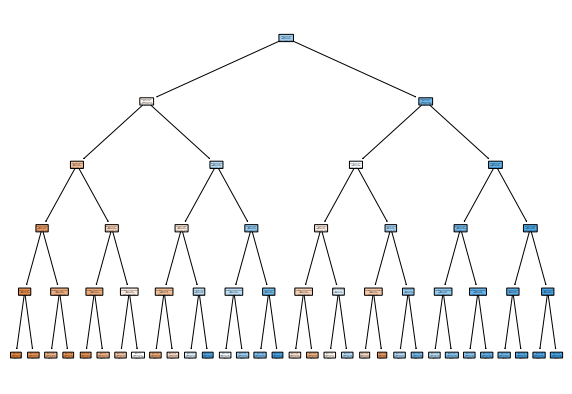

In [36]:
plt.figure(figsize=(10, 7))
plot_tree(best_model, 
          filled=True, 
          rounded=True,
          class_names=['0', 
                       '1'],
          feature_names=training_test[use_cols].columns) 

plt.show()

In [37]:
tree_estimator = gs.best_estimator_
tree_estimator

DecisionTreeClassifier(max_depth=5, random_state=123)

In [38]:
tree_estimator.feature_importances_

array([0.00230193, 0.00312822, 0.4515914 , 0.50325577, 0.03972267,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

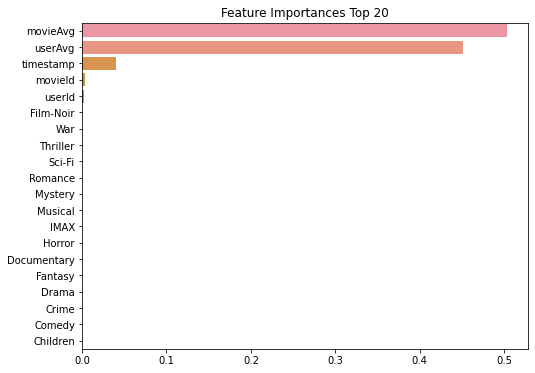

In [39]:
feature_importance_values = tree_estimator.feature_importances_
feature_importances = pd.Series(feature_importance_values, index=training_test[use_cols].columns) # x train's column values
feature_top20 = feature_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 20')
sns.barplot(x=feature_top20, y=feature_top20.index)
plt.show()

- movieAverage was the most important feature in the prediction model
    - movie's quality/social standard in general affects individuals' rate 
- userAverage was the second > so each person's rating standard/rating tendancy affects actual rate
    - someone could send out 0 for dislike and 3 or like but someone else could send 5 for all movies
    
- timestamp represents seconds that have elapsed since the Unix epoch 00:00:00 UTC on midnight UTC of Janurary 1, 1970
    - https://en.wikipedia.org/wiki/Unix_time
    - Thus when the movie was watched also affects the rate
    
- genres in the other hand doesn't significantly affect the rate 

In [ ]:
# plot_decision_regions(np.asarray(copy.deepcopy(training_test[plot_cols])).astype('float32'), np.array(copy.deepcopy(y_train)), gs)

# plt.tight_layout()
# plt.show()